In [210]:
def simulate_margin(products, dates, loc, scale):
    import numpy as np
    import pandas as pd

    n_products = len(products)
    n_days = len(dates)    

    scale_diff = scale/np.sqrt(n_days)
    product_baseline = np.random.normal(loc=loc,scale=scale,size=(n_products,1))
    product_diff = np.random.normal(loc=0, scale=scale_diff, size=(n_products, n_days-1))
    margins = np.cumsum(np.concatenate([product_baseline, product_diff], axis=1), axis=1)
    margins = pd.DataFrame(margins, columns=dates)
    margins["product_id"] = products
    return margins

def plot_simulated_data(data, setup):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt


    x, y, hue = setup["x"], setup["y"], setup["hue"]
    labs = setup["labs"]
    fig, axs = plt.subplots(1,2, figsize=(20,7.5))
    # walk
    sns.lineplot(data=data,
        x=x, y=y, hue=hue,
        legend=False, palette=sns.color_palette("rocket_r", as_cmap=True),
        alpha=0.5, ax=axs[0]);
    axs[0].set_ylabel(labs["y"]);
    axs[0].tick_params(axis='x', rotation=90);
    axs[0].set_xlabel(labs["x"]);
    # hist
    sns.histplot(data=data,
        x=y, bins=50,
        color=sns.color_palette("rocket",10)[1],
        ax=axs[1]);
    axs[1].set_ylabel("frequency");
    axs[1].set_xlabel(labs["y"]);

def get_purchases(path="../data/raw/retailrocket/events"):
    import numpy as np
    import pandas as pd

    events = pd.read_parquet(path).drop_duplicates()
    purchases = events[events.event_type_name=="purchase"]
    purchases.loc[:,"date"] = purchases.event_time.dt.date
    purchases["week_start"] = purchases["date"] -\
        pd.to_timedelta(purchases["event_time"].dt.dayofweek, unit="d")
    return purchases    

def get_acp(purchases, margins, target_size=4):
    import pandas as pd
    from itertools import product

    purchases = purchases.merge(margins, on=["product_id","date"], how="inner")
    purchases["profit"] = purchases.revenue*purchases.margin
    purchases = purchases.groupby(["user_id", "week_start"], as_index=False)\
        .agg(profit=("profit", sum), revenue=("revenue", sum))
    user_week_product = product(purchases.user_id.unique(), purchases.week_start.unique())
    user_acp = pd.DataFrame(user_week_product, columns=["user_id", "week_start"])\
        .merge(purchases, on=["user_id", "week_start"], how="left")\
            .fillna(0).sort_values("week_start")\
                .rename(columns={"week_start":"date"})
    user_acp["acp"] = target_size*user_acp.groupby("user_id").profit.cumsum()/\
        (user_acp.groupby("user_id").cumcount()+1)
    return user_acp.loc[:,["user_id", "date", "acp"]]

#NOTE: CLEAN UP LOC FROM NAMING - CLASHING WITH THE METHODS WHEN USING DOTS
def simulate_acp(purchases, loc, scale, seed=0):
    import numpy as np
    import pandas as pd
    
    np.random.seed(seed)
    dates = purchases.sort_values("week_start").week_start.unique()
    products = purchases.product_id.unique()
    margins = simulate_margin(products, dates, loc, scale)
    margins = pd.melt(margins, id_vars=["product_id"],
            var_name="date", value_name="margin")
    user_acp = get_acp(purchases, margins, 4)
    #return pd.DataFrame([[loc, scale, seed, user_acp.acp.mean(), user_acp.acp.std()]],
    #    columns=["loc","scale", "seed", "mu", "sigma"])        
    user_acp["loc"] = loc
    user_acp["scale"] = scale
    user_acp["seed"] = seed
    return user_acp

### Simulate margin & estimate ACP

/tmp/ipykernel_521/3858961302.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases.loc[:,"date"] = purchases.event_time.dt.date
/home/mf/github/churn-modeling/.env/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1189: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  warnings.warn(
/tmp/ipykernel_521/3858961302.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchases["week_start"] = purchases["date"] -\


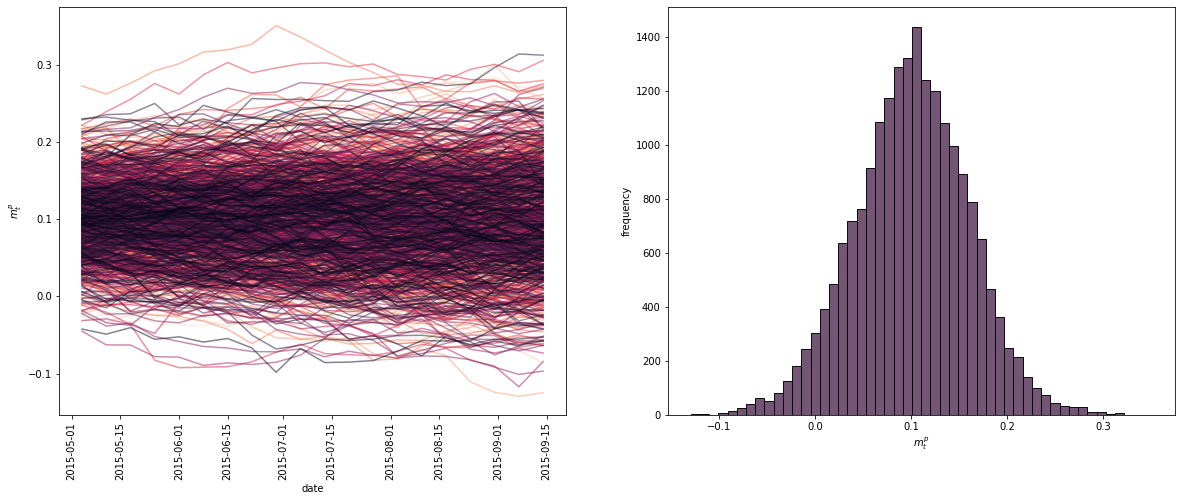

In [211]:
# SIMULATE MARGINS
import pandas as pd
purchases = get_purchases()
# simulation
loc = 0.10
scale = 0.05
dates = purchases.sort_values("week_start").week_start.unique()
products = purchases.product_id.unique()
margins = simulate_margin(products, dates, loc, scale)
margins = pd.melt(margins, id_vars=["product_id"],
        var_name="date", value_name="margin")
# plot
prod_subset = margins.product_id.isin(margins.product_id.unique()[:1000])
plot_conf = {"x":"date", "y":"margin", "hue":"product_id", "labs":{"x":"date", "y":"$m^p_t$"}}    
plot_simulated_data(margins[prod_subset], plot_conf)

DescribeResult(nobs=3401, minmax=(-2133.124022403269, 396829.41162089026), mean=13982.268015805827, variance=1122269608.882347, skewness=4.142984952788187, kurtosis=21.918607440330792)

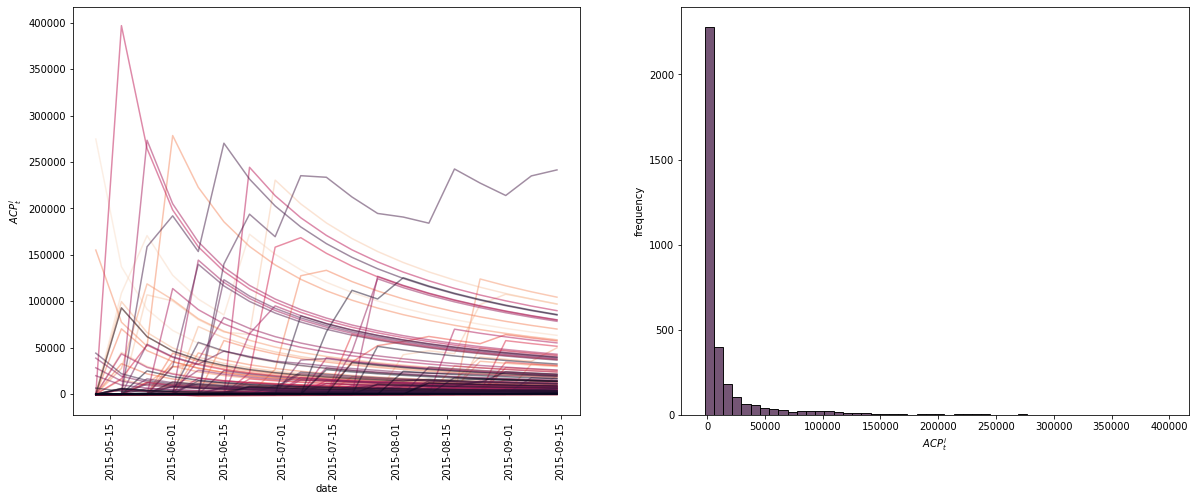

In [212]:
user_acp =  get_acp(purchases, margins, target_size=4)
plot_conf = {"x":"date", "y":"acp", "hue":"user_id", "labs":{"x":"date", "y":"$ACP^i_t$"}} 
plot_simulated_data(user_acp, plot_conf)

from scipy.stats import describe
describe(user_acp.acp)

### Sensitivity analysis

In [213]:
from itertools import product
import numpy as np
from multiprocessing import Pool

mu_range = [0.05,0.15,0.25]
sigma_range = [0.05, 0.1, 0.15]
seed_range = np.random.randint(low=0, high=2**16, size=100)

def para_sacp(params):
    return simulate_acp(purchases,
        params[0], params[1], params[2])

def get_sim_stats(df):
    import numpy as np
    from scipy import stats

    loc = df["loc"].unique()[0]
    scale = df["scale"].unique()[0]
    mu =  df["acp"].mean()
    lb, ub =  np.percentile(df["acp"], q=[2.5, 97.5])
    ads = stats.describe(df["acp"])
    return pd.DataFrame([[loc, scale, mu, lb, ub, ads]], columns=["loc","scale","mu","lb","ub","summary"])

In [214]:
# simulate
with Pool() as poo:
    sensitivity_simulation = poo.map(para_sacp,
        product(mu_range, sigma_range, seed_range))
sensitivity_simulation =  pd.concat(sensitivity_simulation)
# get stats    
sensitivity_summary = sensitivity_simulation.groupby(
    ["loc","scale"], as_index=False).apply(get_sim_stats)
sensitivity_summary

,,loc,scale,mu,lb,ub,summary
0,0,0.05,0.05,6898.966583,-1342.475614,59313.950861,"(340100, (-137580.4714356308, 306916.906106199..."
1,0,0.05,0.10,6919.582845,-10127.545031,70117.151847,"(340100, (-383710.54287126166, 485269.38660012..."
2,0,0.05,0.15,6940.199107,-21876.162599,82682.348442,"(340100, (-629840.6143068925, 673629.279900185..."
3,0,0.15,0.05,20655.667224,0.000000,163007.711615,"(340100, (-20123.566779552348, 679924.9061062)..."
4,0,0.15,0.10,20676.283486,-170.270764,169289.625429,"(340100, (-166611.3428712617, 800337.812212399..."
5,0,0.15,0.15,20696.899748,-4027.426841,177941.852582,"(340100, (-412741.41430689255, 920750.71831859..."
6,0,0.25,0.05,34412.367866,0.000000,270225.604311,"(340100, (-53.65083099130197, 1052932.90610619..."
7,0,0.25,0.10,34432.984128,0.000000,273380.123654,"(340100, (-53511.22767675176, 1173345.8122124)..."
8,0,0.25,0.15,34453.600390,0.000000,279617.295567,"(340100, (-195642.21430689248, 1293758.7183185..."


In [ ]:
# MAYBE CI FOR MU?
# RE-RUN ON REES46?

In [ ]:
# DEVELOP TOY EXAMPLE FOR THE PROFIT SIM AND EVAL